<a href="https://colab.research.google.com/github/gguex/ISH_ressources_cours_ML/blob/main/TP04_knn_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 4 : kNN et SVM

Dans ce quatrième TP, nous allons faire un kNN et un SVM pour de la classification sur un jeu de données.

Un exercice consitera à chercher le meilleur modèle (parmi une liste de modèles proposés) sur un autre jeu de données.

Les librairies et modules nécessaires sont

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Pour modifier la taille de sortie de graphiques dans le notebook
plt.rcParams['figure.figsize'] = [12, 12]
# Pour le traitement des données
from sklearn.preprocessing import StandardScaler
# le kNN et les SVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# Pour la CV
from sklearn.model_selection import train_test_split, GridSearchCV, \
  RandomizedSearchCV
# Pour sauver un modèle
import pickle

Nous commençons par charger le jeu de données, qui consiste en des données chimiques sur des vins italiens, de la même région, mais de 3 cépages différents. Le détail de ces données peut être trouvé ici (https://archive.ics.uci.edu/dataset/109/wine). Il y a 13 variables numériques (les données chimiques) et 1 variable catégorielle avec 3 modalités (le cépage).

In [2]:
file_path = "drive/MyDrive/Colab Notebooks/ml_data/TP4/wine.data"
data = pd.read_csv(file_path, header=None)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


Pour les méthodes que nous allons utiliser, comme fréquemment pour d'autres méthodes de ML, il est important de **standardiser** les variables numériques. On utilise pour cela la classe `StandardScaler()` de `sklearn`. Notez que cette opération n'était pas nécessaire pour la régression linéaire ou logistique, mais peut éventuellement s'effectuer (mais dans ce cas, l'interprétation des coefficients de régression devient plus délicate).

In [3]:
# On standardise et sauve les entrées
inputs = StandardScaler().fit_transform(data.drop([0], axis=1))
# On sauve les sorties
outputs = data[0]
# On sépare le jeu de données
inputs_train_val, inputs_test, outputs_train_val, outputs_test \
  = train_test_split(inputs, outputs, test_size=0.3, stratify=outputs)
# On regarde les entrées standardisées
pd.DataFrame(inputs)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.876275,2.974543,0.305159,0.301803,-0.332922,-0.985614,-1.424900,1.274310,-0.930179,1.142811,-1.392758,-1.231206,-0.021952
174,0.493343,1.412609,0.414820,1.052516,0.158572,-0.793334,-1.284344,0.549108,-0.316950,0.969783,-1.129518,-1.485445,0.009893
175,0.332758,1.744744,-0.389355,0.151661,1.422412,-1.129824,-1.344582,0.549108,-0.422075,2.224236,-1.612125,-1.485445,0.280575
176,0.209232,0.227694,0.012732,0.151661,1.422412,-1.033684,-1.354622,1.354888,-0.229346,1.834923,-1.568252,-1.400699,0.296498


On entraine notre modèle des $k$ plus proches voisins, en testant les valeurs de $k$ entre 1 et 30. La cross-validation se fera avec 4 folds

In [4]:
# Paramètres pour le nombre de voisins
k_par = list(range(1, 31))
param_dict = {"n_neighbors": k_par}
n_cv = 4
# Recherche sur grille avec CV
knn_classifier = KNeighborsClassifier()
gride_search_knn = GridSearchCV(knn_classifier,
                                param_dict,
                                cv=n_cv)
gride_search_knn.fit(inputs_train_val, outputs_train_val)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]})

On peut obtenir le meilleur modèle grâce à l'attribut `best_estimator_` de notre instance `gride_search_knn`, ainsi que nos meilleurs paramètres avec l'attribut `best_params_`. Un object contenant un modèle entrainé peut calculer directement l'exactitude (le score pas défaut) sur des entrées-sorties données avec la méthode `score()`

In [5]:
accuracy_knn_test = gride_search_knn.best_estimator_.score(inputs_test,
                                                           outputs_test)
best_k = gride_search_knn.best_params_["n_neighbors"]

On affiche les résultats

In [6]:
print(f"kNN: meilleure paramètre k = {best_k}")
print(f"kNN: meilleure exactitude d'entrainement = "
      f"{gride_search_knn.best_score_: .2%}")
print(f"kNN: meilleure exactitude de test = {accuracy_knn_test: .2%}")

kNN: meilleure paramètre k = 1
kNN: meilleure exactitude d'entrainement =  98.39%
kNN: meilleure exactitude de test =  92.59%


Ici, nous allons colorer les différentes zones de décision. On va afficher 7 graphiques, avec à chaque fois une paire de variables numériques sur les axes (pour voir nos 13 variables). Des estimations du k-NN se feront sur chaque point d'une grille, et les variables omises seront fixées à zéro (elles sont centrées, 0 est donc leur moyenne) afin de pouvoir estimer la classe de ces points.

Les prédictions des points de la grille sont affichées grâce à la fonction `pcolormesh()` de `matplotlib.pyplot`.

Le résultat peut être contre-intuitif, car les individus affichés ne sont pas forcément dans le plan de coupe (leurs autres variables ne sont certainement pas 0). Mais la "forme" des zones de décision obtenue est typique de la méthode utilisée.

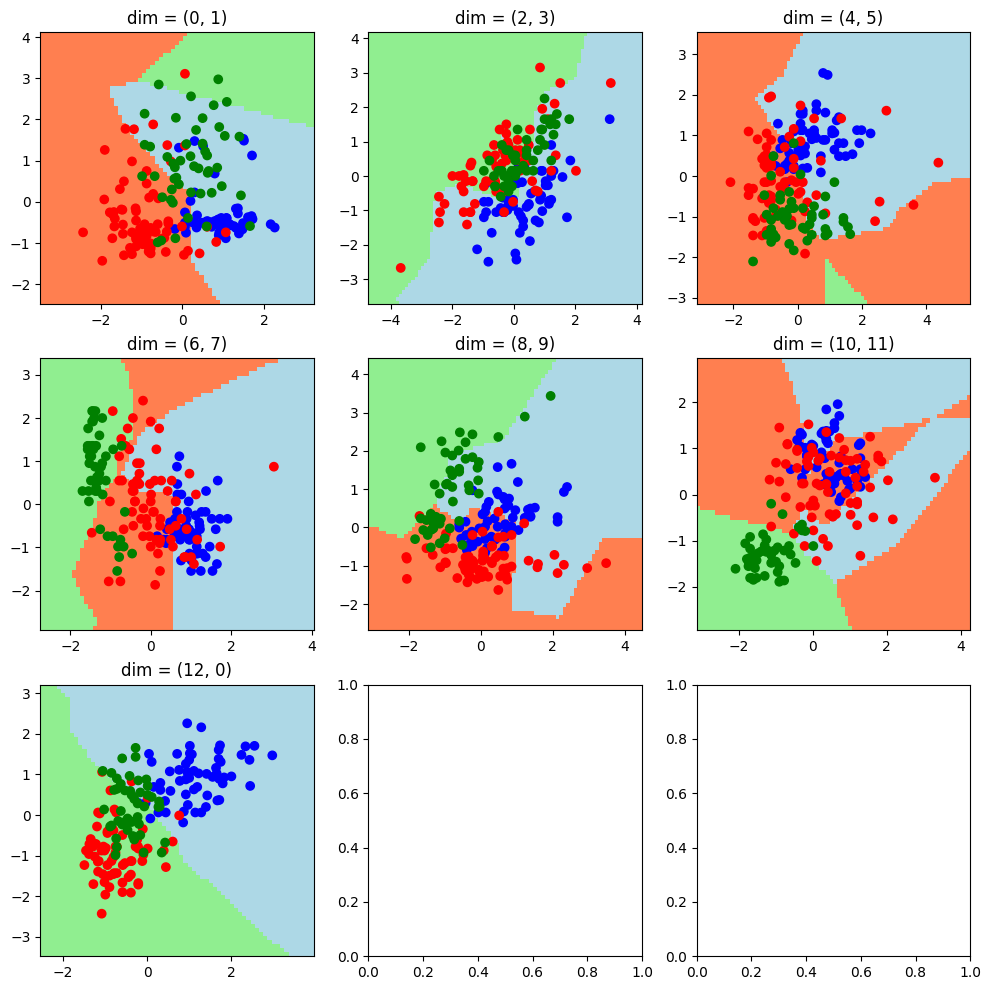

In [7]:
# Les dimensions que nous allons examiner
dim_list = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11), (12, 0)]
# La position des graphs dans le carré
pos_list = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0)]
# Nos couleurs
mesh_cmap = ListedColormap(["lightblue", "coral", "lightgreen"])
points_cmap = ListedColormap(["blue", "red", "green"])
# La taille de la mesh
mesh_size = 0.1

# On créé le graphique
fig, axs = plt.subplots(3, 3)

# On fait une boucle sur les dimensions
for i, dim in enumerate(dim_list):
  # On restreint les données
  X = inputs[:, dim]
  # On fixe les limites
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  # On définit notre mesh
  xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                        np.arange(y_min, y_max, mesh_size))
  # On définit les inputs
  new_values = np.c_[xx.ravel(), yy.ravel()]
  grid_input = np.zeros((new_values.shape[0], inputs.shape[1]))
  grid_input[:, dim] = new_values
  # On fait les prédictions, que l'on transforme en valeurs numériques
  grid_pred = gride_search_knn.best_estimator_.predict(grid_input)
  grid_pred_num = pd.Series(grid_pred).replace(["M", "F", "I"], [0, 1, 2])
  grid_pred_num = grid_pred_num.to_numpy().reshape(xx.shape)

  # On fait le graphique
  axs[pos_list[i]].pcolormesh(xx, yy, grid_pred_num, cmap=mesh_cmap)
  axs[pos_list[i]].scatter(X[:, 0], X[:, 1], c=outputs, cmap=points_cmap)
  axs[pos_list[i]].set_title(f"dim = {dim}")

On refait la même méthode avec un SVM et un kernel RBF (radial basis function). On va faire une recherche sur 2 hyperparamètres, $C$ et $\gamma$. Comme le SVM est relativement lent et que l'espace des hyperparamètres est grand (si on veut tout tester, on aura $n_C \times n_\gamma \times k$ tests où $n_C$ est le nombre de valeurs de $C$, $n_\gamma$ le nombre de valeurs de $\gamma$, et $k$ le nombre de folds), on va plutôt faire un `RandomizedSearchCV()`, c'est-à-dire une recherche aléatoire, avec que 30 points de test. Le paramètre `verbose=4` permet d'afficher des informations lors de l'entrainement (plus il est élevé, plus on a d'information)

In [8]:
c_par = np.linspace(2, 10, 5)
gamma_par = np.linspace(0.01, 1, 20)
param_dict = {"C": c_par, "gamma": gamma_par}
n_cv = 4
svm_classifier = SVC()
# Recherche sur grille avec CV
gride_search_svm = RandomizedSearchCV(svm_classifier,
                                      param_dict,
                                      n_iter=30,
                                      cv=n_cv,
                                      verbose=4)
gride_search_svm.fit(inputs_train_val, outputs_train_val)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV 1/4] END ..C=2.0, gamma=0.37473684210526315;, score=1.000 total time=   0.0s
[CV 2/4] END ..C=2.0, gamma=0.37473684210526315;, score=0.935 total time=   0.0s
[CV 3/4] END ..C=2.0, gamma=0.37473684210526315;, score=0.935 total time=   0.0s
[CV 4/4] END ..C=2.0, gamma=0.37473684210526315;, score=0.903 total time=   0.0s
[CV 1/4] END ..C=2.0, gamma=0.21842105263157896;, score=1.000 total time=   0.0s
[CV 2/4] END ..C=2.0, gamma=0.21842105263157896;, score=1.000 total time=   0.0s
[CV 3/4] END ..C=2.0, gamma=0.21842105263157896;, score=0.968 total time=   0.0s
[CV 4/4] END ..C=2.0, gamma=0.21842105263157896;, score=0.935 total time=   0.0s
[CV 1/4] END ...C=8.0, gamma=0.6352631578947369;, score=0.774 total time=   0.0s
[CV 2/4] END ...C=8.0, gamma=0.6352631578947369;, score=0.839 total time=   0.0s
[CV 3/4] END ...C=8.0, gamma=0.6352631578947369;, score=0.742 total time=   0.0s
[CV 4/4] END ...C=8.0, gamma=0.6352631578947369

RandomizedSearchCV(cv=4, estimator=SVC(), n_iter=30,
                   param_distributions={'C': array([ 2.,  4.,  6.,  8., 10.]),
                                        'gamma': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
                   verbose=4)

On affiche les résultats, afin de les comparer avec la méthode précédente

In [9]:
accuracy_svm_test = gride_search_svm.best_estimator_.score(inputs_test,
                                                           outputs_test)
print(f"SVM: meilleures paramètres {gride_search_svm.best_params_}")
print(f"SVM: meilleure exactitude d'entrainement = "
      f"{gride_search_svm.best_score_: .2%}")
print(f"SVM: meilleure exactitude de test = {accuracy_svm_test: .2%}")

SVM: meilleures paramètres {'gamma': np.float64(0.16631578947368422), 'C': np.float64(2.0)}
SVM: meilleure exactitude d'entrainement =  98.39%
SVM: meilleure exactitude de test =  94.44%


Finalement, on fait les 4 graphiques comme précédemment. On voit que les zones de décision ont un aspect très différent, malgré des preformances sensiblement identiques

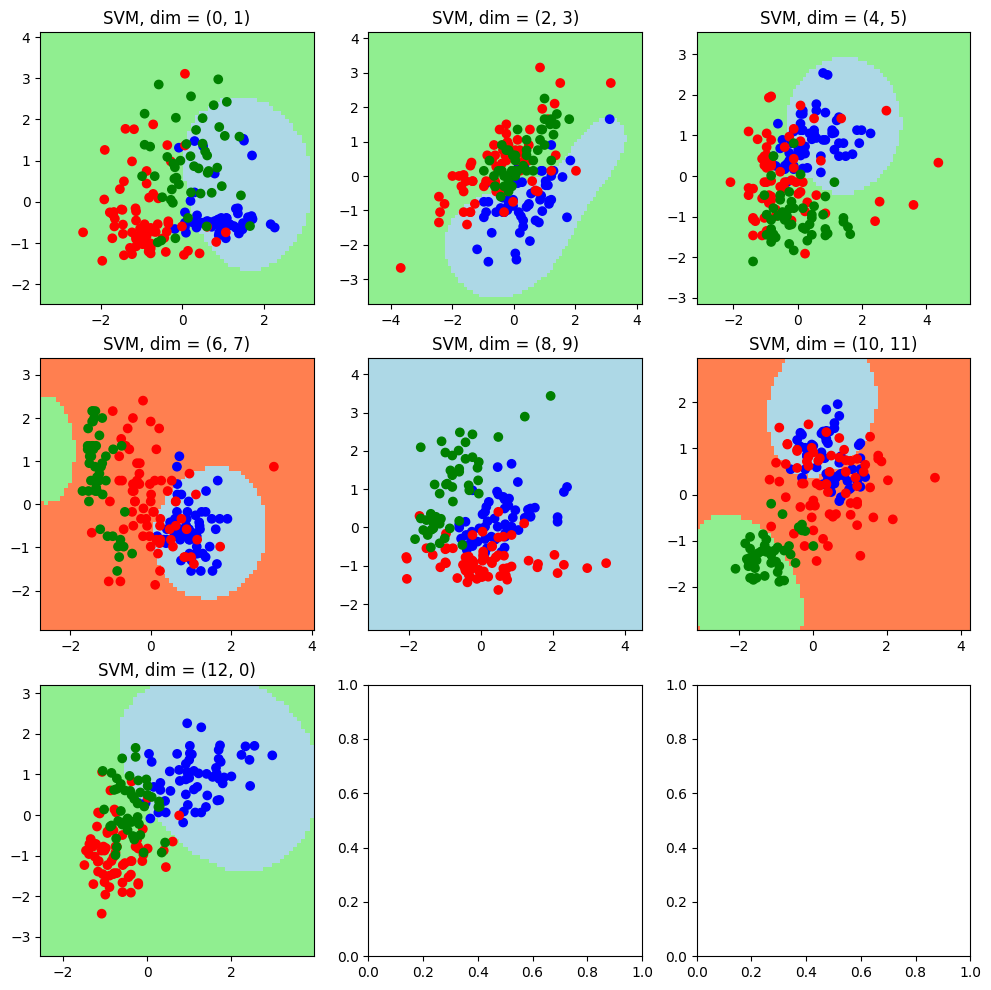

In [10]:
# On créée le graphique
fig, axs = plt.subplots(3, 3)

# On fait une boucle sur les dimensions
for i, dim in enumerate(dim_list):
  # On restreint les données
  X = inputs[:, dim]
  # On fixe les limites
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  # On définit notre mesh
  xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                        np.arange(y_min, y_max, mesh_size))
  # On définit les inputs
  new_values = np.c_[xx.ravel(), yy.ravel()]
  grid_input = np.zeros((new_values.shape[0], inputs.shape[1]))
  grid_input[:, dim] = new_values
  # On fait les prédictions, que l'on transforme en valeurs numériques
  grid_pred = gride_search_svm.best_estimator_.predict(grid_input)
  grid_pred_num = pd.Series(grid_pred).replace(["M", "F", "I"], [0, 1, 2])
  grid_pred_num = grid_pred_num.to_numpy().reshape(xx.shape)

  # On fait le graphique
  axs[pos_list[i]].pcolormesh(xx, yy, grid_pred_num, cmap=mesh_cmap)
  axs[pos_list[i]].scatter(X[:, 0], X[:, 1], c=outputs, cmap=points_cmap)
  axs[pos_list[i]].set_title(f"SVM, dim = {dim}")

Pour sauver un modèle, on peut utiliser la libraire `pickle`, qui permet de sauvegarder des objets Python. Il faut faire attention d'écrire et de lire dans des fichiers en "binaire" (options `"wb"` et `"rb"` dans la fonction `open()`).

In [11]:
# Sauvegarder le modèle
model_path = "drive/MyDrive/Colab Notebooks/ml_data/TP4/svm_model.sav"
with open(model_path, "wb") as model_file_out:
  pickle.dump(gride_search_svm.best_estimator_, model_file_out)

# Charger le modèle
with open(model_path, "rb") as model_file_in:
  best_model = pickle.load(model_file_in)
best_model

SVC(C=np.float64(2.0), gamma=np.float64(0.16631578947368422))

Cette sauvgarde permet d'échanger des modèles entre chercheur.euse.s, ou de fournir à la communauté des modèles dont l'entrainement prend énormément de temps et de ressources.

---

 ## Exercice

Dans cet exercice, vous allez tenter de trouver le meilleur modèle possible sur le jeu de données "Social_Network_Ads.csv" (plus d'info https://www.kaggle.com/datasets/rakeshrau/social-network-ads).

Les prétraitements suivant doivent être faits:

* La variable à prédire est **Purchased**, qui est binaire.
* La variable **Gender** doit être transformée en valeur binaire.
* Laissez tomber la variable **User ID**.
* Toutes les variables d'entrée doivent être standardisées.

Les modèles que vous devez tester sont les suivants:

* SVM avec RBF.
* SVM avec kernel polynomial.
* k plus proches voisins.

A vous de voir quels hyperparmètres vous voulez tester.

Bonne chance !